In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
pd.set_option(
    'display.max_rows', 100
)
url ="http://publicplansdata.org/api/"
focus_plans_list=['101', '110', '125', '179']
most_improved_list=['124', '90', '89', '134', '123']
least_improved_list=['41', '122', '120', '40', '119']
hardest_hit_list=['168', '130', '184', '151', '31']

In [3]:
#Create dictionary of study plan ids
study_plans_dict={"Steady":focus_plans_list,
                        "Most Improved":most_improved_list,
                        "Least Improved":least_improved_list,
                        "Hardest Hit":hardest_hit_list}

In [4]:
#Set parameters
paramsratios = {
    "q": "QDataset",
    "dataset": "pensiongasbschedules",
     "format": "json"
}
paramsbasicplandata = {
    "q": "QDataset",
    "dataset": "pensionplanbasics",
     "format": "json"
}
paramspenincomestatement = {
    "q": "QDataset",
    "dataset": "pensionincomestatement",
     "format": "json"
}

In [5]:
#create requests
ratiosresponse = requests.get(url, params = paramsratios)
plandataresponse = requests.get(url,params=paramsbasicplandata)
penincomestatementresponse = requests.get(url,params=paramspenincomestatement)

In [6]:
#create json response object
fundedratiosdata = ratiosresponse.json()
plandata = plandataresponse.json()
penincomestatement = penincomestatementresponse.json()

In [7]:
#change response object into DataFrame
funded_ratios_full = pd.DataFrame(fundedratiosdata[1:])
plan_data_full = pd.DataFrame(plandata[1:])
penincomestatement_data_full = pd.DataFrame(penincomestatement[1:])

In [8]:
plan_data_df=plan_data_full[['ppd_id','PlanName','StateAbbrev','PlanClosed','PlanYearClosed',]]

In [9]:
#Create DF and drop any rows with empty data
penincomestatement_data_df=penincomestatement_data_full[['ppd_id','fy','expense_AdminExpenses','expense_investments_tot','MktAssets_net','BegMktAssets_net']].dropna()
funded_ratio_df=funded_ratios_full[['ppd_id','fy','ActFundedRatio_GASB','ActFundedRatio_est','PercentReqContPaid']].dropna()

In [10]:
plan_income_data_df=pd.merge(penincomestatement_data_df,plan_data_df,how="inner",on="ppd_id")
plan_income_data_df['expense_AdminExpenses'] = plan_income_data_df['expense_AdminExpenses'].astype(float)
plan_income_data_df['expense_investments_tot'] = plan_income_data_df['expense_investments_tot'].astype(float)

In [11]:
plan_income_funded_data_df=pd.merge(plan_income_data_df,funded_ratio_df,how="inner",left_on=["ppd_id","fy"],right_on=["ppd_id","fy"])

In [12]:
plan_income_funded_data_df['ActFundedRatio_GASB'] = plan_income_funded_data_df['ActFundedRatio_GASB'].astype(float)
plan_income_funded_data_df['PercentReqContPaid'] = plan_income_funded_data_df['PercentReqContPaid'].astype(float)
plan_income_funded_data_df['MktAssets_net'] = plan_income_funded_data_df['MktAssets_net'].astype(float)
plan_income_funded_data_df['BegMktAssets_net'] = plan_income_funded_data_df['BegMktAssets_net'].astype(float)

In [13]:
plan_income_funded_data_df['Avg_Assets']=(plan_income_funded_data_df['MktAssets_net']+plan_income_funded_data_df['BegMktAssets_net'])/2
plan_income_funded_data_df['Total_absExpenses']=plan_income_funded_data_df['expense_AdminExpenses'].abs()+plan_income_funded_data_df['expense_investments_tot'].abs()

In [14]:
plan_income_funded_data_df['Exp_Asset_Ratio']=plan_income_funded_data_df['Total_absExpenses']/plan_income_funded_data_df['Avg_Assets']
plan_income_funded_data_df['Exp_Asset_Ratio'].describe()

count    3416.000000
mean        0.004877
std         0.002948
min         0.000003
25%         0.002889
50%         0.004384
75%         0.006293
max         0.027690
Name: Exp_Asset_Ratio, dtype: float64

In [15]:
y_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"].isin(focus_plans_list),"Exp_Asset_Ratio"]
x_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"].isin(focus_plans_list),"ActFundedRatio_GASB"]
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

In [16]:
line_eq

'y = 0.01x + -0.0'

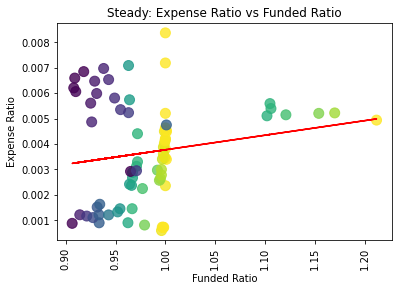

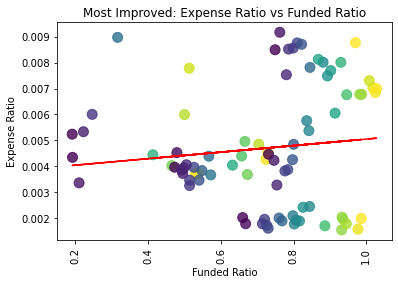

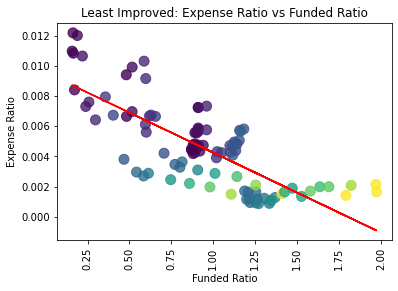

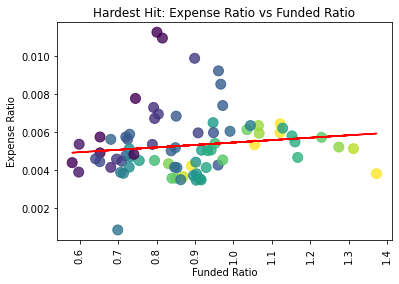

In [17]:
#Generate single plot for each key in the dictionary
for key,value in study_plans_dict.items():
    for plans in value:
        plan_x=plan_income_funded_data_df[plan_income_funded_data_df["ppd_id"]==plans]
        plan_x_exprat=plan_x["Exp_Asset_Ratio"]
        plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
        plan_x_fy=plan_x["fy"]
        plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
        plt.title(f'{key}: Expense Ratio vs Funded Ratio')
        plt.xlabel("Funded Ratio")
        plt.ylabel("Expense Ratio")
        plt.scatter(plan_x_fundrat,plan_x_exprat,c=plan_x_fundrat,s=100,alpha=.8)
        plt.xticks(rotation=90)
    #Generate linear regression    
    y_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"].isin(value),"Exp_Asset_Ratio"]
    x_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"].isin(value),"ActFundedRatio_GASB"]
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.plot(x_values,regress_values,"r-")
    plt.savefig(f'plot images/all_{key}_exprat_fundrat.png')
    plt.show()

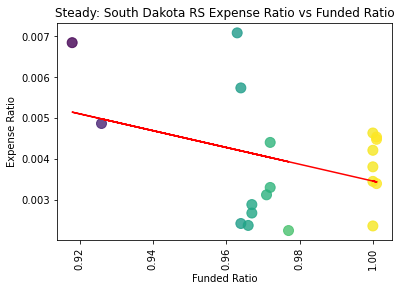

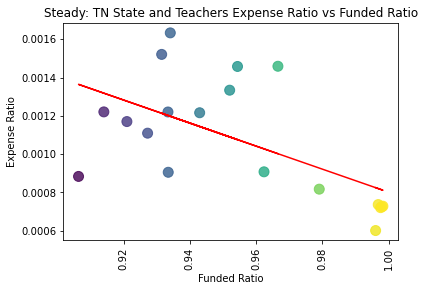

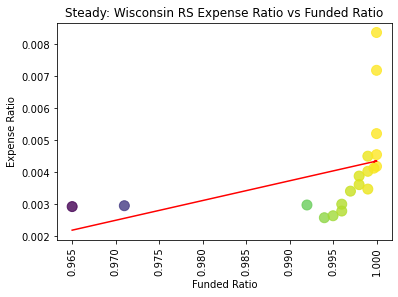

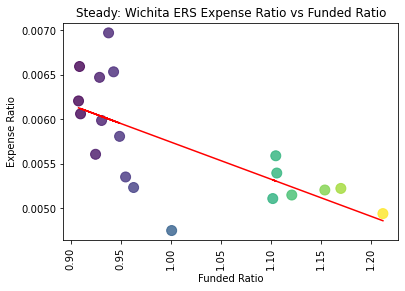

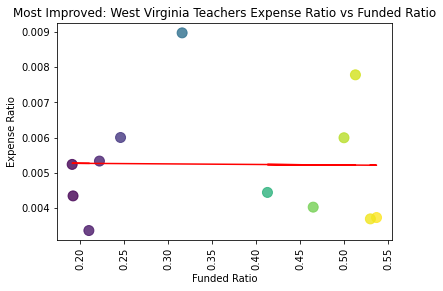

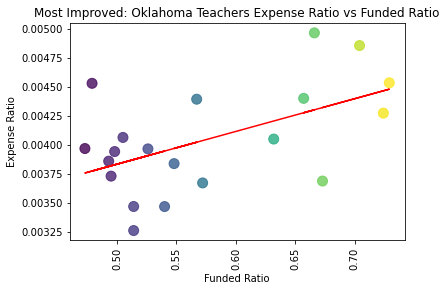

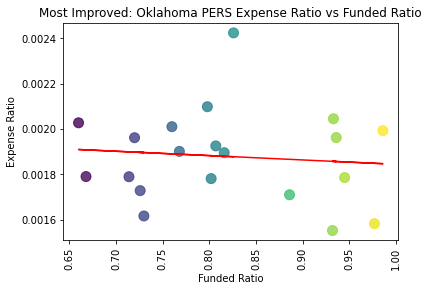

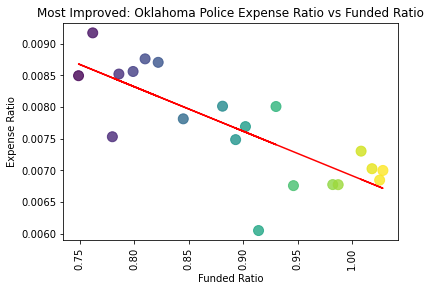

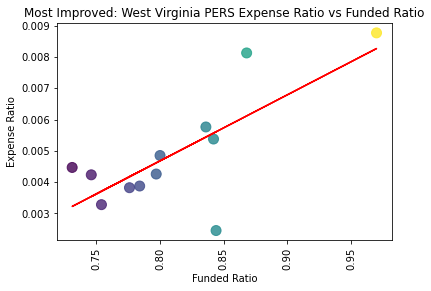

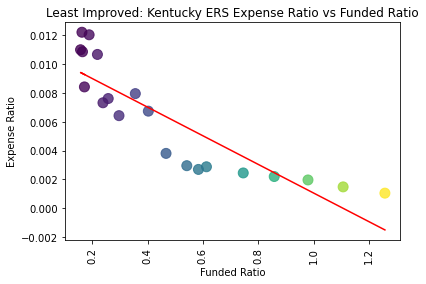

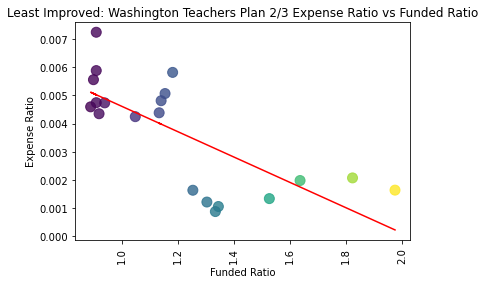

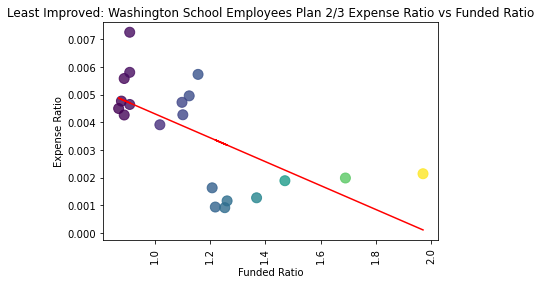

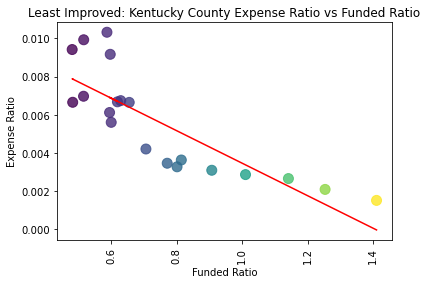

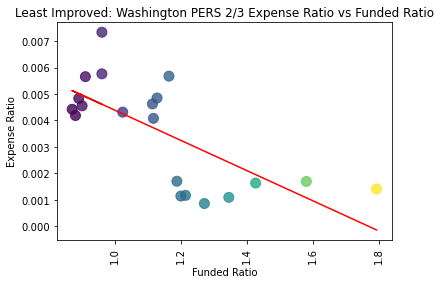

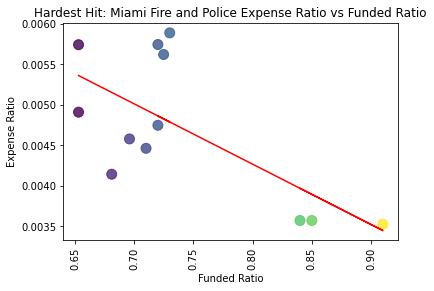

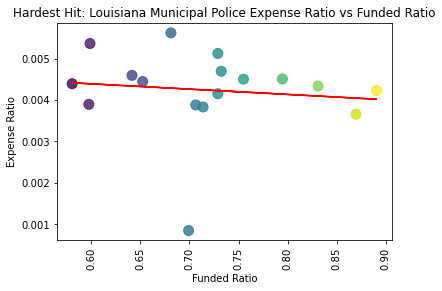

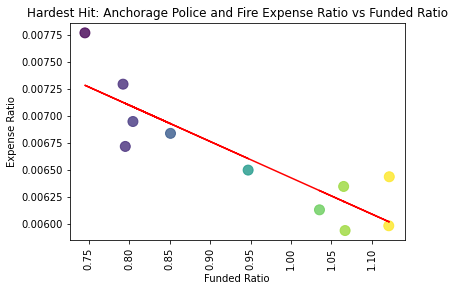

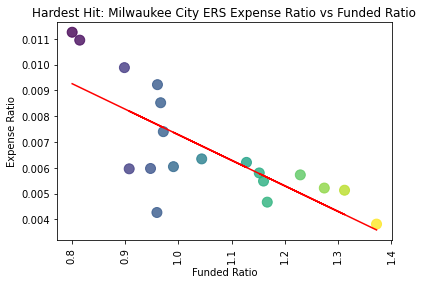

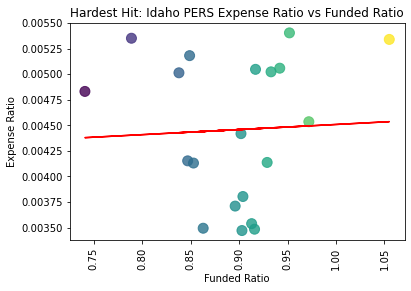

In [18]:
#Generate individual plots for all values in the dictionary
for key,value in study_plans_dict.items():
    for plans in value:
        plan_x=plan_income_funded_data_df[plan_income_funded_data_df["ppd_id"]==plans]
        plan_x_exprat=plan_x["Exp_Asset_Ratio"]
        plan_x_fundrat=plan_x["ActFundedRatio_GASB"]
        plan_x_fy=plan_x["fy"]
        plan_x_name=plan_data_df.loc[plan_data_df['ppd_id'] == plans, 'PlanName'].iloc[0]
        plt.title(f'{key}: {plan_x_name} Expense Ratio vs Funded Ratio')
        plt.xlabel("Funded Ratio")
        plt.ylabel("Expense Ratio")
        plt.scatter(plan_x_fundrat,plan_x_exprat,c=plan_x_fundrat,s=100,alpha=.8)
        plt.xticks(rotation=90)
        #Generate linear regression    
        y_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"]==plans,"Exp_Asset_Ratio"]
        x_values = plan_income_funded_data_df.loc[plan_income_funded_data_df["ppd_id"]==plans,"ActFundedRatio_GASB"]
        (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
        regress_values = x_values * slope + intercept
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        plt.plot(x_values,regress_values,"r-")
        plt.savefig(f'plot images/{key}_{plans}_exprat_fundrat.png')
        plt.show()